In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D 

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# helper function to plot curves
def make_plot(x_values, y_values, x_label, y_label, title):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(x_values, y_values)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

In [4]:
random_state = 2020

## Load and prepare dataset

In [5]:
df = pd.read_csv("Shill Bidding Dataset.csv")

X = df.drop(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# Use MinMaxScaler because data has outliers, and we want to highlight those
scaler = MinMaxScaler() 

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 

# Part 1: Clustering

## K-means clustering

In [6]:
%%time
sse = []
silhouettes = []
k_range = range(2,len(X_train.columns)+1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_train, kmeans.labels_, random_state=random_state))

CPU times: user 4.43 s, sys: 697 ms, total: 5.12 s
Wall time: 16.9 s


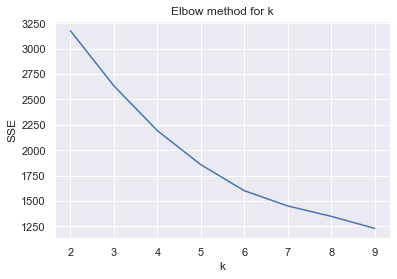

In [7]:
make_plot(x_values=k_range, 
          y_values=sse, 
          x_label='k', 
          y_label='SSE',
          title='Elbow method for k')

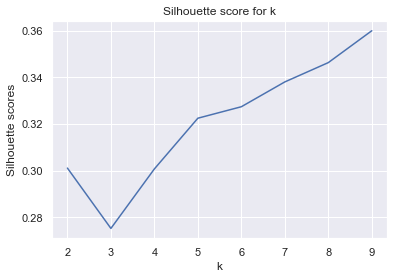

In [8]:
make_plot(x_values=k_range, 
          y_values=silhouettes, 
          x_label='k', 
          y_label='Silhouette scores',
          title='Silhouette score for k')

In [9]:
# modified code from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

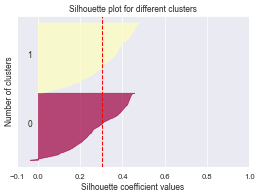

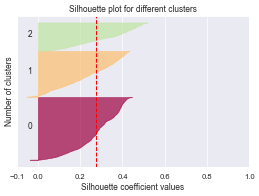

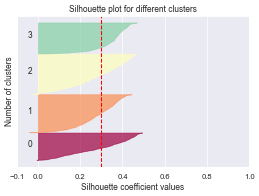

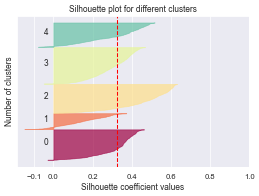

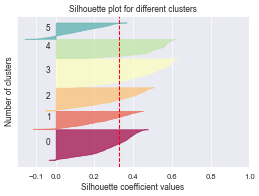

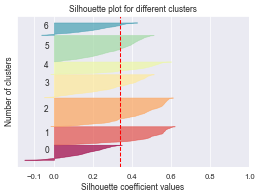

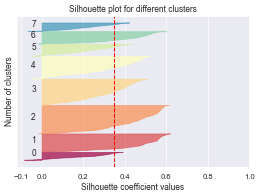

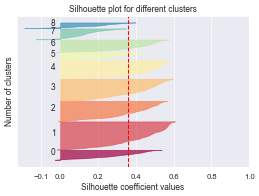

In [10]:
for k in k_range:
    plt.figure(dpi=50)
    ax1 = plt.gca()
    
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(X_train)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_train, labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, labels)
    
    y_lower = 100
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("Silhouette plot for different clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Number of clusters")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [11]:
kmeans_2, kmeans_3, kmeans_4 = [KMeans(n_clusters=n, random_state=random_state) for n in [2,3,4]]
kmeans_2.fit(X_train)
kmeans_3.fit(X_train)
kmeans_4.fit(X_train)            
labels_2, labels_3, labels_4 = kmeans_2.labels_, kmeans_3.labels_, kmeans_4.labels_

In [12]:
df_2 = pd.DataFrame(labels_2, columns={'labels'})
df_3 = pd.DataFrame(labels_3, columns={'labels'})
df_4 = pd.DataFrame(labels_4, columns={'labels'})

In [13]:
df_2.groupby('labels')['labels'].count() / len(df_2)

labels
0    0.489376
1    0.510624
Name: labels, dtype: float64

In [14]:
df_3.groupby('labels')['labels'].count() / len(df_3)

labels
0    0.458409
1    0.334539
2    0.207052
Name: labels, dtype: float64

In [15]:
df_4.groupby('labels')['labels'].count() / len(df_4)

labels
0    0.199593
1    0.278481
2    0.295208
3    0.226718
Name: labels, dtype: float64

In [16]:
df['Class'].value_counts()/len(df)

0    0.893213
1    0.106787
Name: Class, dtype: float64

## Expectation Maximization

In [17]:
%%time
n_components_values = range(2, len(X_train.columns)+1)
bic_values = []
aic_values = []
silhouettes = []

for n_components in n_components_values:
    gmm = GaussianMixture(n_components=n_components, 
                          random_state=random_state)
    gmm.fit(X_train)
    bic_values.append(gmm.bic(X_train))
    aic_values.append(gmm.aic(X_train))
    silhouettes.append(silhouette_score(X_train, gmm.predict(X_train), random_state=random_state))

CPU times: user 4.74 s, sys: 736 ms, total: 5.48 s
Wall time: 30.3 s


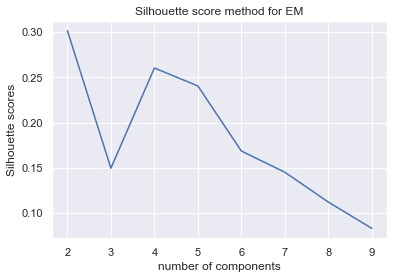

In [18]:
make_plot(x_values=n_components_values, 
          y_values=silhouettes, 
          x_label='number of components', 
          y_label='Silhouette scores',
          title='Silhouette score method for EM')

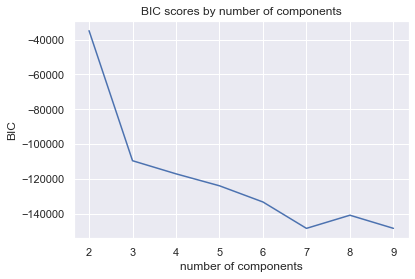

In [19]:
make_plot(x_values=n_components_values, 
          y_values=bic_values, 
          x_label='number of components', 
          y_label='BIC',
          title='BIC scores by number of components')

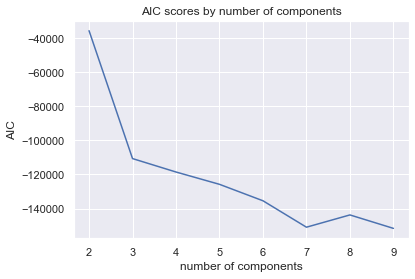

In [20]:
make_plot(x_values=n_components_values, 
          y_values=aic_values, 
          x_label='number of components', 
          y_label='AIC',
          title='AIC scores by number of components')

In [21]:
bic_values.index(min(bic_values))+2

7

In [22]:
len(X_train.columns)

9

In [23]:
aic_values.index(min(aic_values))+2

9

# Part 2: Dimensionality Reduction

## PCA

In [24]:
pca = PCA(random_state=random_state)
features = pca.fit_transform(X_train)
pca.fit(X_train)

PCA(random_state=2020)

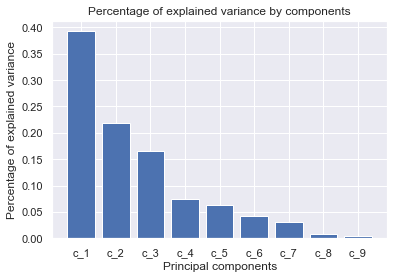

In [25]:
explained_variance = pca.explained_variance_ratio_
labels = ['c_' + str(x) for x in range(1,len(explained_variance)+1)]
plt.bar(x=list(range(1,len(explained_variance)+1)), height=explained_variance, tick_label=labels)
plt.xlabel('Principal components')
plt.ylabel('Percentage of explained variance')
plt.title('Percentage of explained variance by components');

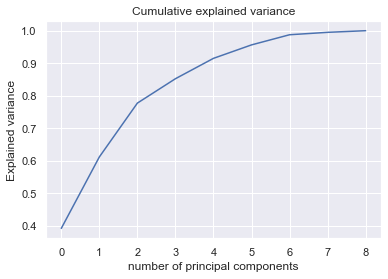

In [26]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
make_plot(x_values=list(range(len(cumulative_variance))), 
          y_values=cumulative_variance, 
          x_label='number of principal components', 
          y_label='Explained variance',
          title='Cumulative explained variance')

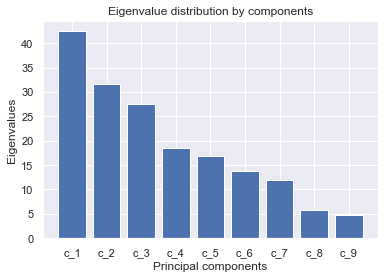

In [27]:
eigenvalues = pca.singular_values_
labels = ['c_' + str(x) for x in range(1,len(eigenvalues)+1)]
plt.bar(x=list(range(1,len(eigenvalues)+1)), height=eigenvalues, tick_label=labels)
plt.xlabel('Principal components')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalue distribution by components');

In [28]:
pca = PCA(n_components=3, random_state=random_state)
features = pca.fit_transform(X_train)
c1_var, c2_var, c3_var = pca.explained_variance_ratio_

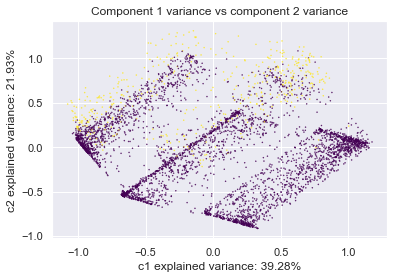

In [29]:
ax = plt.figure().gca(title='Component 1 variance vs component 2 variance', 
                                   xlabel='c1 explained variance: {}%'.format(round(c1_var*100, 2)), 
                                   ylabel='c2 explained variance: {}%'.format(round(c2_var*100, 2))
                                  )
ax.scatter(features[:, 0], features[:, 1], c=y_train, s=0.2, cmap = 'viridis');

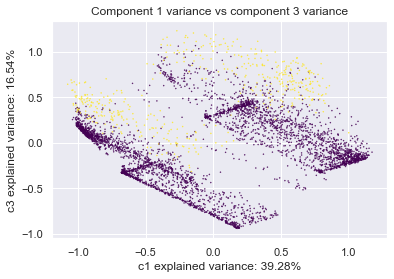

In [30]:
ax = plt.figure().gca(title='Component 1 variance vs component 3 variance', 
                                   xlabel='c1 explained variance: {}%'.format(round(c1_var*100, 2)), 
                                   ylabel='c3 explained variance: {}%'.format(round(c3_var*100, 2))
                                  )
ax.scatter(features[:, 0], features[:, 2], c=y_train, s=0.2, cmap = 'viridis');

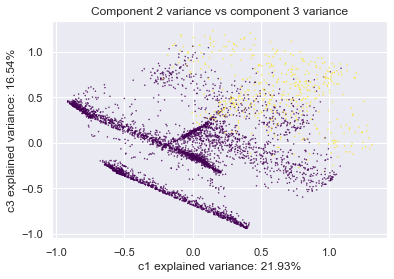

In [31]:
ax = plt.figure().gca(title='Component 2 variance vs component 3 variance', 
                                   xlabel='c1 explained variance: {}%'.format(round(c2_var*100, 2)), 
                                   ylabel='c3 explained variance: {}%'.format(round(c3_var*100, 2))
                                  )
ax.scatter(features[:, 1], features[:, 2], c=y_train, s=0.2, cmap = 'viridis');

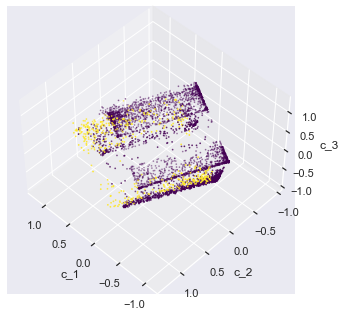

In [32]:
fig = plt.figure(figsize=(5,4))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=48, azim=134)

plt.cla()
ax.set_xlabel('c_1')
ax.set_ylabel('c_2')
ax.set_zlabel('c_3')

ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=y_train, cmap = 'viridis', s=0.6);

## ICA

In [33]:
ica = FastICA(random_state=random_state, whiten=True)
S_ = ica.fit_transform(X_train)

In [34]:
kurtosis_values = []
n_components_values = range(2,len(X_train.columns)+1)

for n_components in n_components_values:
    ica = FastICA(n_components=n_components, 
                  random_state=random_state)
    S_ = ica.fit_transform(X_train)
    kurtosis_df = pd.DataFrame(S_)
    kurtosis_df = kurtosis_df.kurt(axis=0)
    kurtosis_values.append(kurtosis_df.abs().mean())

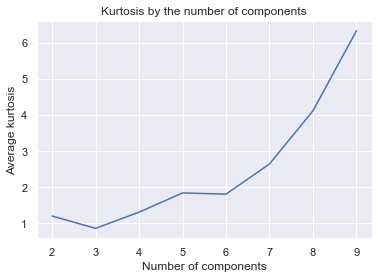

In [35]:
make_plot(x_values=list(n_components_values), 
          y_values=kurtosis_values, 
          x_label='Number of components', 
          y_label='Average kurtosis',
          title='Kurtosis by the number of components')

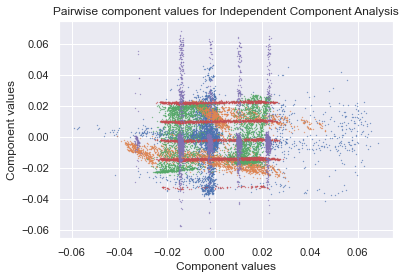

In [36]:
n_components=5

ica = FastICA(random_state=random_state, whiten=True)
ica_data = ica.fit_transform(X_train)

plt.figure()
plt.xlabel('Component values')
plt.ylabel('Component values')
plt.title('Pairwise component values for Independent Component Analysis')
for n in range(n_components):
    plt.scatter(ica_data[:,n], ica_data[:,(n+1)%n_components], s=0.1)

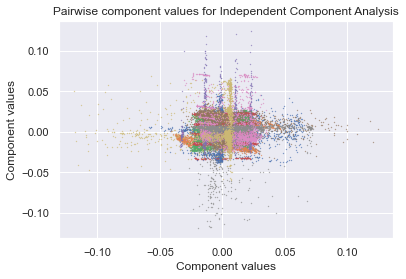

In [37]:
n_components=9

ica = FastICA(random_state=random_state, whiten=True)
ica_data = ica.fit_transform(X_train)

plt.figure()
plt.xlabel('Component values')
plt.ylabel('Component values')
plt.title('Pairwise component values for Independent Component Analysis')
for n in range(n_components):
    plt.scatter(ica_data[:,n], ica_data[:,(n+1)%n_components], s=0.1)

## Randomized Projection

In [38]:
error_values = []
n_components_values = range(2,len(X_train.columns)+1)

for n_components in n_components_values:
    rp = GaussianRandomProjection(n_components=n_components, 
                                  random_state=random_state)
    X_transformed = rp.fit_transform(X_train)
    psuedoinverse = np.linalg.pinv(rp.components_.T)
    reconstructed = X_transformed.dot(psuedoinverse)
    error = mean_squared_error(X_train, reconstructed)
    error_values.append(error)

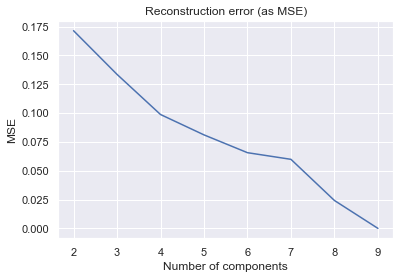

In [39]:
make_plot(x_values=list(n_components_values), 
          y_values=error_values, 
          x_label='Number of components', 
          y_label='MSE',
          title='Reconstruction error (as MSE)')

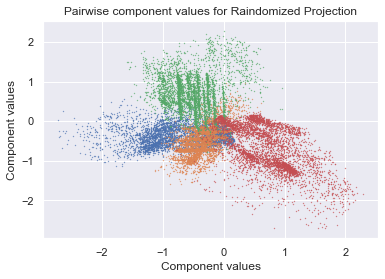

In [40]:
n_components = 4

rp = GaussianRandomProjection(n_components=n_components, 
                              random_state=random_state)
rp_data = rp.fit_transform(X_train)

plt.figure()
plt.xlabel('Component values')
plt.ylabel('Component values')
plt.title('Pairwise component values for Raindomized Projection')
for n in range(n_components):
    plt.scatter(rp_data[:,n], rp_data[:,(n+1)%n_components], s=0.1)

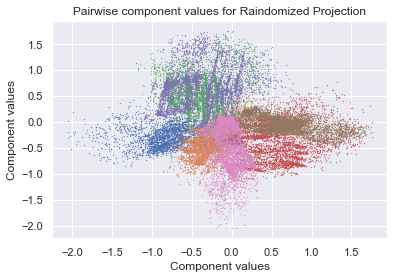

In [41]:
n_components = 7

rp = GaussianRandomProjection(n_components=n_components, 
                              random_state=random_state)
rp_data = rp.fit_transform(X_train)

plt.figure()
plt.xlabel('Component values')
plt.ylabel('Component values')
plt.title('Pairwise component values for Raindomized Projection')
for n in range(n_components):
    plt.scatter(rp_data[:,n], rp_data[:,(n+1)%n_components], s=0.1)

#### Try different random states

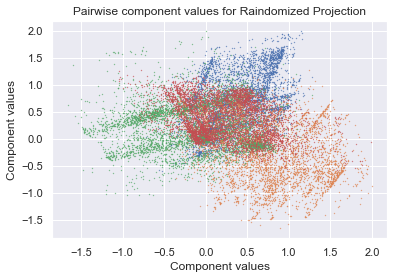

In [42]:
n_components = 4

rp = GaussianRandomProjection(n_components=n_components, 
                              random_state=1791)
rp_data = rp.fit_transform(X_train)

plt.figure()
plt.xlabel('Component values')
plt.ylabel('Component values')
plt.title('Pairwise component values for Raindomized Projection')
for n in range(n_components):
    plt.scatter(rp_data[:,n], rp_data[:,(n+1)%n_components], s=0.1)

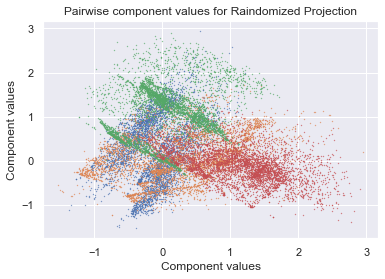

In [43]:
n_components = 4

rp = GaussianRandomProjection(n_components=n_components, 
                              random_state=1453)
rp_data = rp.fit_transform(X_train)

plt.figure()
plt.xlabel('Component values')
plt.ylabel('Component values')
plt.title('Pairwise component values for Raindomized Projection')
for n in range(n_components):
    plt.scatter(rp_data[:,n], rp_data[:,(n+1)%n_components], s=0.1)

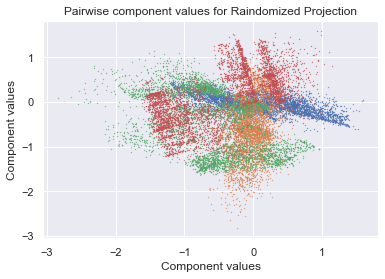

In [44]:
n_components = 4

rp = GaussianRandomProjection(n_components=n_components, 
                              random_state=9000)
rp_data = rp.fit_transform(X_train)

plt.figure()
plt.xlabel('Component values')
plt.ylabel('Component values')
plt.title('Pairwise component values for Raindomized Projection')
for n in range(n_components):
    plt.scatter(rp_data[:,n], rp_data[:,(n+1)%n_components], s=0.1)

## Select from Model

In [45]:
# from https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [46]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, y_train)

In [47]:
selector.estimator_.coef_

array([[ 0.9383286 ,  1.11167866,  7.86826162,  0.57282874,  0.23373279,
         0.31971837, -0.56664617,  3.444009  ,  0.55543966]])

In [48]:
selector.threshold_

1.734515954323121

In [49]:
selector.get_support()

array([False, False,  True, False, False, False, False,  True, False])

In [50]:
selector.transform(X_train)

array([[0.   , 0.   ],
       [0.   , 0.   ],
       [0.   , 0.875],
       ...,
       [0.   , 0.   ],
       [0.   , 0.   ],
       [0.   , 0.   ]])

In [51]:
print(X_train.columns[2], ',', X_train.columns[7])

Successive_Outbidding , Winning_Ratio


# Part 3: Clustering on Adjusted Data Space

## Create Adjusted Data Space

In [52]:
pca = PCA(n_components=3, random_state=random_state)
pca_features = pca.fit_transform(X_train)

In [53]:
ica = FastICA(n_components=5, random_state=random_state, whiten=True)
ica_features = ica.fit_transform(X_train)

In [54]:
rp = GaussianRandomProjection(n_components=7, 
                              random_state=random_state)
rp_features = rp.fit_transform(X_train)

In [55]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, y_train)
selector_features = selector.transform(X_train)

## Clustering on Adjusted Data Space

### k-means clustering

In [56]:
def k_means_report(X_train):
    sse = []
    silhouettes = []
    k_range = range(2,len(X_train.columns)+1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X_train)
        sse.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_train, kmeans.labels_, random_state=random_state))
        
    make_plot(x_values=k_range, 
          y_values=sse, 
          x_label='k', 
          y_label='SSE',
          title='Elbow method for k')
    
    make_plot(x_values=k_range, 
          y_values=silhouettes, 
          x_label='k', 
          y_label='Silhouette scores',
          title='Silhouette score for k')
    
    for k in k_range:
        plt.figure(dpi=50)
        ax1 = plt.gca()

        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X_train)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X_train, labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_train, labels)

        y_lower = 100
        for i in range(k):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            cmap = cm.get_cmap("Spectral")
            color = cmap(float(i) / k)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for different clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Number of clusters")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

CPU times: user 2.95 s, sys: 503 ms, total: 3.46 s
Wall time: 11.8 s


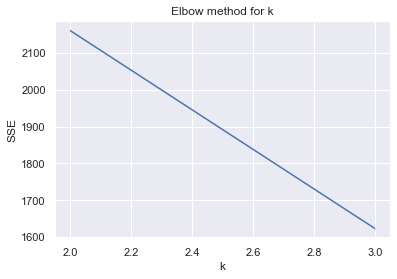

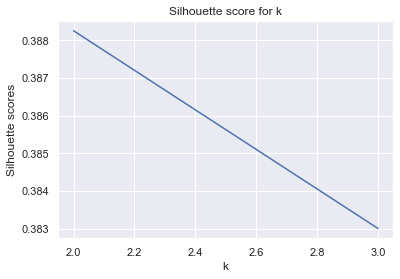

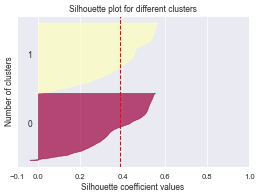

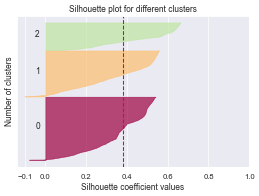

In [57]:
%%time
k_means_report(pd.DataFrame(pca_features))

CPU times: user 5.9 s, sys: 1 s, total: 6.9 s
Wall time: 21 s


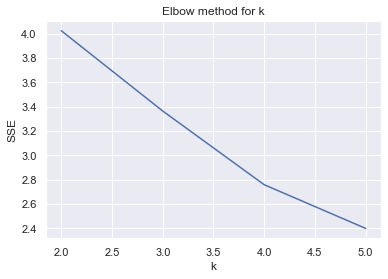

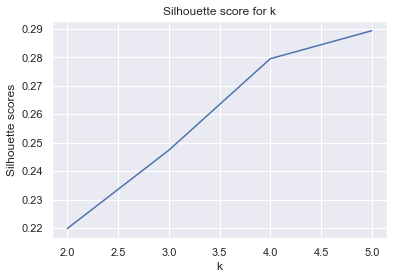

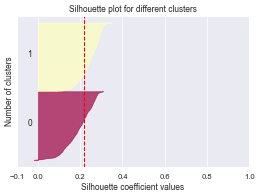

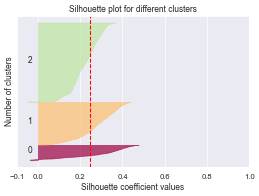

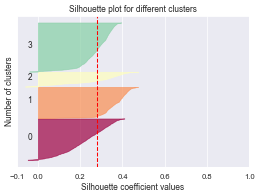

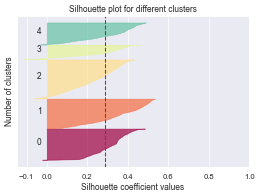

In [58]:
%%time
k_means_report(pd.DataFrame(ica_features))

CPU times: user 10.5 s, sys: 1.62 s, total: 12.1 s
Wall time: 59.5 s


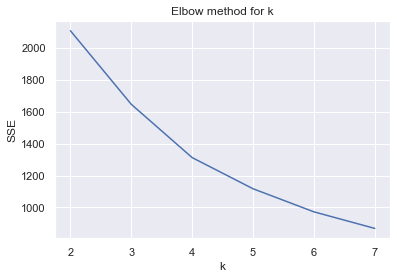

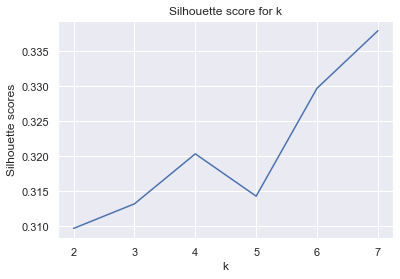

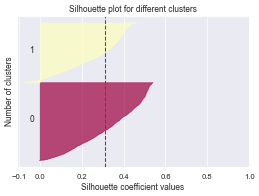

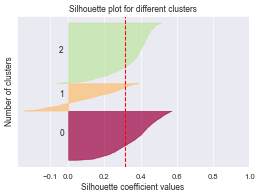

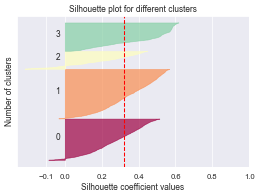

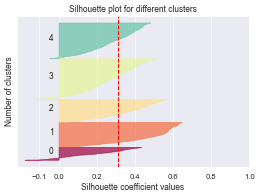

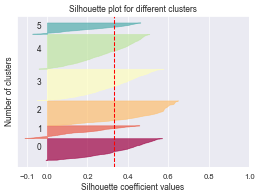

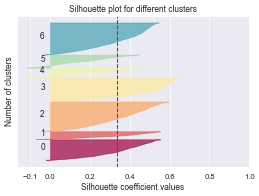

In [59]:
%%time
k_means_report(pd.DataFrame(rp_features))

CPU times: user 1.3 s, sys: 236 ms, total: 1.54 s
Wall time: 2.64 s


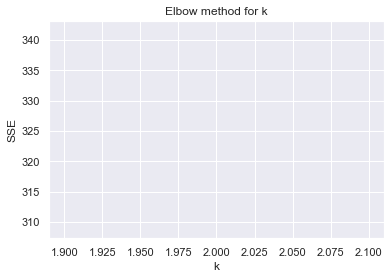

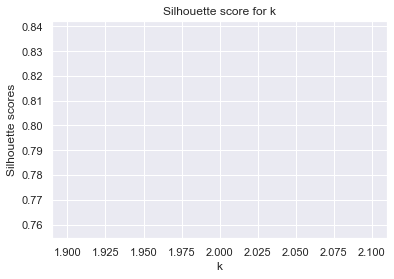

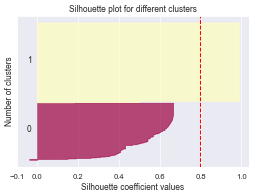

In [60]:
%%time
k_means_report(pd.DataFrame(selector_features))

### Expectation Maximization

In [61]:
def em_report(X_train):
    n_components_values = range(2, len(X_train.columns)+1)
    bic_values = []
    aic_values = []
    silhouettes = []

    for n_components in n_components_values:
        gmm = GaussianMixture(n_components=n_components, 
                              random_state=random_state)
        gmm.fit(X_train)
        bic_values.append(gmm.bic(X_train))
        aic_values.append(gmm.aic(X_train))
        silhouettes.append(silhouette_score(X_train, gmm.predict(X_train), random_state=random_state))

    make_plot(x_values=n_components_values, 
              y_values=silhouettes, 
              x_label='number of components', 
              y_label='Silhouette scores',
              title='Silhouette score method for EM')

    make_plot(x_values=n_components_values, 
              y_values=bic_values, 
              x_label='number of components', 
              y_label='BIC',
              title='BIC scores by number of components')

    make_plot(x_values=n_components_values, 
              y_values=aic_values, 
              x_label='number of components', 
              y_label='AIC',
              title='AIC scores by number of components')

    print('BIC min:', bic_values.index(min(bic_values))+2)
    print('AIC min:', aic_values.index(min(aic_values))+2)
    print('All features total:', len(X_train.columns))

BIC min: 3
AIC min: 3
All features total: 3
CPU times: user 931 ms, sys: 153 ms, total: 1.08 s
Wall time: 1.94 s


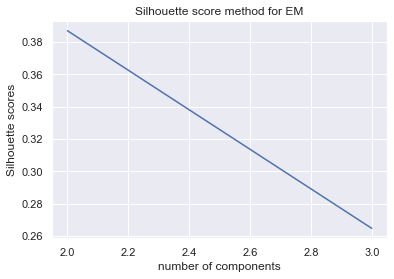

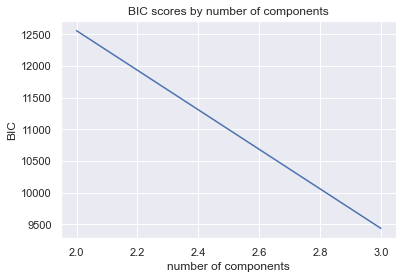

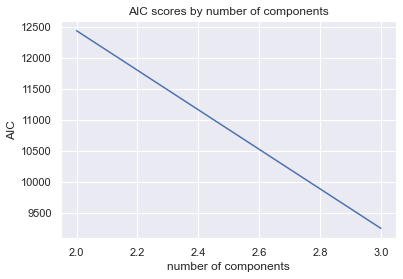

In [62]:
%%time
em_report(pd.DataFrame(pca_features))

BIC min: 5
AIC min: 5
All features total: 5
CPU times: user 2.07 s, sys: 344 ms, total: 2.41 s
Wall time: 8.66 s


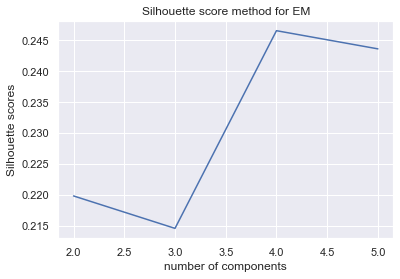

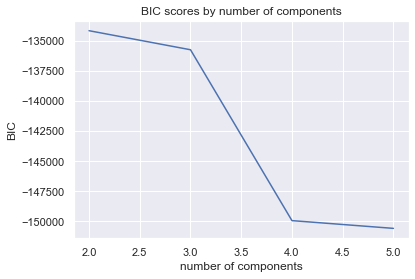

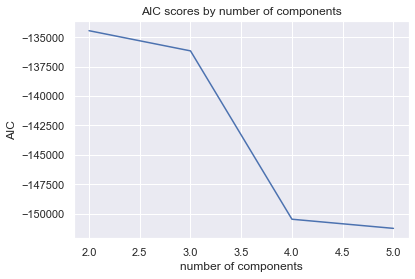

In [63]:
%%time
em_report(pd.DataFrame(ica_features))

BIC min: 7
AIC min: 7
All features total: 7
CPU times: user 3.5 s, sys: 537 ms, total: 4.04 s
Wall time: 16.6 s


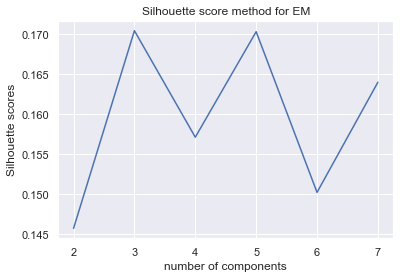

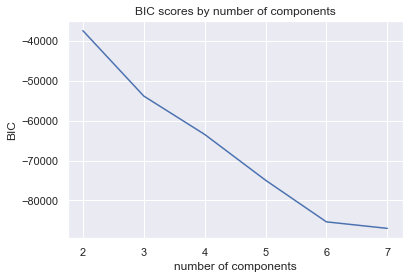

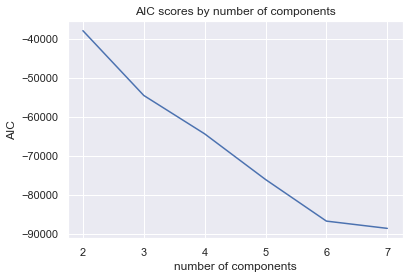

In [64]:
%%time
em_report(pd.DataFrame(rp_features))

BIC min: 2
AIC min: 2
All features total: 2
CPU times: user 489 ms, sys: 79.2 ms, total: 568 ms
Wall time: 863 ms


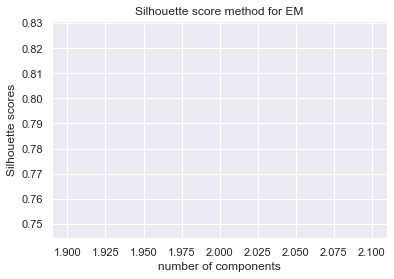

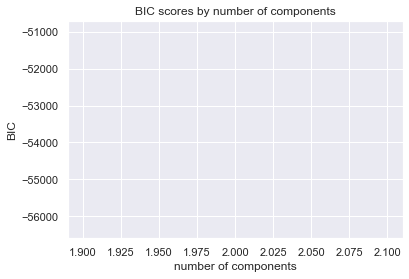

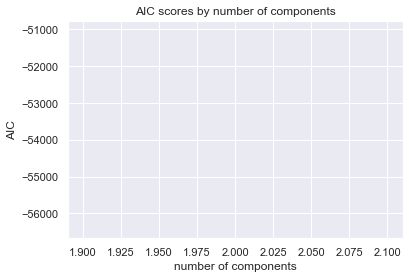

In [65]:
%%time
em_report(pd.DataFrame(selector_features))